In [1]:
import os
os.chdir('../../..')

In [2]:
import convokit

In [3]:
from convokit import Corpus
import pickle
import numpy as np
import os
from tensorly.decomposition import parafac
from convokit.tensors.utils import plot_factors
from sklearn.preprocessing import StandardScaler
from collections import defaultdict, Counter
from jinja2 import Environment, FileSystemLoader
import matplotlib.pyplot as plt
import seaborn as sns
import random
import warnings

In [4]:
CORPUS_DIR = "../thread_generator/fake-corpus-trajectory"
# CORPUS_DIR = "reddit-corpus-small"
# CORPUS_DIR =
DATA_DIR = "data_fake_trajectory"
PLOT_DIR = "html/graphs_fake_trajectory"
# hyperconv_range = range(0, 9+1)
hyperconv_range = range(2, 20+1)
rank_range = range(3, 3+1)
max_rank = max(rank_range)
anomaly_threshold = 1.5

In [5]:
os.chdir('convokit/tensors')

In [6]:
with open(os.path.join(DATA_DIR, 'tensor.p'), 'rb') as f:
    tensor = pickle.load(f)

In [7]:
with open(os.path.join(DATA_DIR, 'rank_to_factors.p'), 'rb') as f:
    rank_to_factors = pickle.load(f)

In [8]:
with open(os.path.join(DATA_DIR, 'convo_ids.p'), 'rb') as f:
    convo_ids = pickle.load(f)

In [9]:
tensor.shape

(19, 999, 140)

In [11]:
factors = rank_to_factors[3]

In [12]:
factors[0].shape

(19, 3)

In [13]:
factors[1].shape

(999, 3)

In [14]:
factors[2].shape

(140, 3)

In [ ]:
corpus = Corpus(filename=CORPUS_DIR)

In [15]:
from sklearn.preprocessing import Imputer, Normalizer, StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import pairwise_distances

In [84]:
from sklearn.manifold import TSNE
tsne = TSNE(random_state=2020, verbose=1)

In [85]:
print(factors[1].shape)
projected_threads = tsne.fit_transform(factors[1])
print(projected_threads.shape)

(999, 3)
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 999 samples in 0.001s...
[t-SNE] Computed neighbors for 999 samples in 0.014s...
[t-SNE] Computed conditional probabilities for sample 999 / 999
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 53.132423
[t-SNE] KL divergence after 1000 iterations: 0.418061
(999, 2)


In [86]:
import matplotlib.pyplot as plt

In [87]:
import random

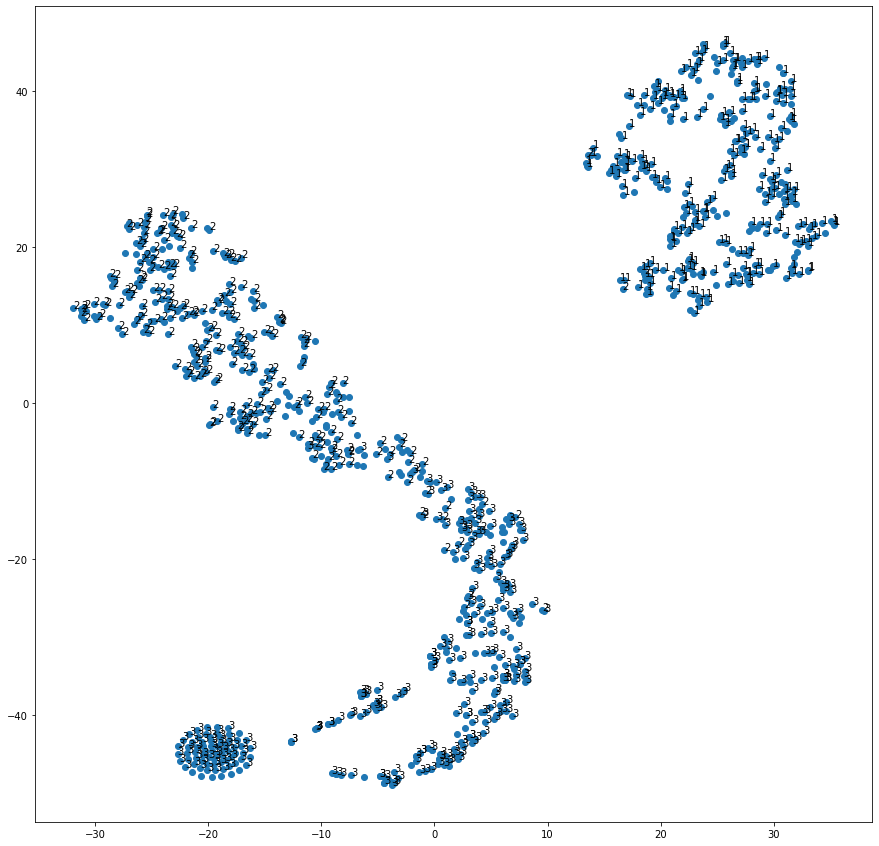

In [90]:
plt.figure(figsize=(15,15))
plt.scatter(projected_threads[:,0], projected_threads[:, 1])

for i in range(tensor.shape[1]):
    if random.random() < 0.8:
        plt.annotate(corpus.get_utterance(convo_ids[i]).meta['subreddit'][0], (projected_threads[i][0], projected_threads[i][1]))
    
plt.show()

## What if we focus further specifically on the positive / negative threads only?

Since these might be most striking and therefore give us a more separated TSNE.

In [41]:
from collections import defaultdict, Counter

In [42]:
anomaly_threshold = 1.5

In [92]:
def get_anomalous_points(factor_full, idx):
    scaler = StandardScaler()
    factor = factor_full[:, idx]
    reshaped = factor.reshape((factor.shape[0], 1))
    scaled = scaler.fit_transform(reshaped)
    pos_pts = np.argwhere(scaled.reshape(factor.shape[0]) > anomaly_threshold).flatten()
    neg_pts = np.argwhere(scaled.reshape(factor.shape[0]) < -anomaly_threshold).flatten()
    return pos_pts, neg_pts

def generate_high_level_summary():
    # generate_plots()
    with open(os.path.join(DATA_DIR, 'rank_to_factors.p'), 'rb') as f:
        rank_to_factors = pickle.load(f)

    with open(os.path.join(DATA_DIR, 'hg_features.p'), 'rb') as f:
        liwc_features = pickle.load(f)

    with open(os.path.join(DATA_DIR, 'subreddits.p'), 'rb') as f:
        subreddits = pickle.load(f)

    time_factor = rank_to_factors[max_rank][0] # (9, 9)
    thread_factor = rank_to_factors[max_rank][1] # (10000, 9)
    feature_factor = rank_to_factors[max_rank][2] # (140, 9)
    idx_to_distinctive_threads = defaultdict(dict)
    idx_to_distinctive_features = defaultdict(dict)

    # normalizing
    subreddit_totals = Counter(subreddits)
    for idx in range(max_rank):
        pos_thread_pts, neg_thread_pts = get_anomalous_points(thread_factor, idx)
        idx_to_distinctive_threads[idx]['pos_threads'] = pos_thread_pts
        idx_to_distinctive_threads[idx]['neg_threads'] = neg_thread_pts

        pos_features, neg_features = get_anomalous_points(feature_factor, idx)
        idx_to_distinctive_features[idx]['pos_features'] = pos_features
        idx_to_distinctive_features[idx]['neg_features'] = neg_features

    return idx_to_distinctive_threads, idx_to_distinctive_features 

In [93]:
idx_to_distinctive_threads, idx_to_distinctive_features = generate_high_level_summary()

In [94]:
for factor_idx, threads in idx_to_distinctive_threads.items():
    print("Factor {}".format(factor_idx+1))
    print("Number of pos threads: {}".format(len(threads['pos_threads'])))
    print("Number of neg threads: {}".format(len(threads['neg_threads'])))
    print("Positive feats: {}".format(idx_to_distinctive_features[factor_idx]['pos_features']))
    print("Negative feats: {}".format(idx_to_distinctive_features[factor_idx]['neg_features']))
    print()

Factor 1
Number of pos threads: 0
Number of neg threads: 118
Positive feats: [67]
Negative feats: []

Factor 2
Number of pos threads: 105
Number of neg threads: 0
Positive feats: [  4  12  18  21  24  26  61  82  88  94  96 131]
Negative feats: [67]

Factor 3
Number of pos threads: 126
Number of neg threads: 37
Positive feats: [ 61  94 131]
Negative feats: [ 0 13 14 20 37 63 67 69]



In [95]:
included_threads = set()

for factor_idx, threads in idx_to_distinctive_threads.items():
    included_threads = included_threads.union(set(threads['pos_threads'])).union(threads['neg_threads'])

In [96]:
len(included_threads)

293

In [97]:
included_threads = sorted(included_threads)

In [98]:
factors[1][included_threads].shape

(293, 3)

In [99]:
projected_threads = tsne.fit_transform(factors[1][included_threads])
print(projected_threads.shape)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 293 samples in 0.000s...
[t-SNE] Computed neighbors for 293 samples in 0.004s...
[t-SNE] Computed conditional probabilities for sample 293 / 293
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 49.532124
[t-SNE] KL divergence after 1000 iterations: 0.218128
(293, 2)


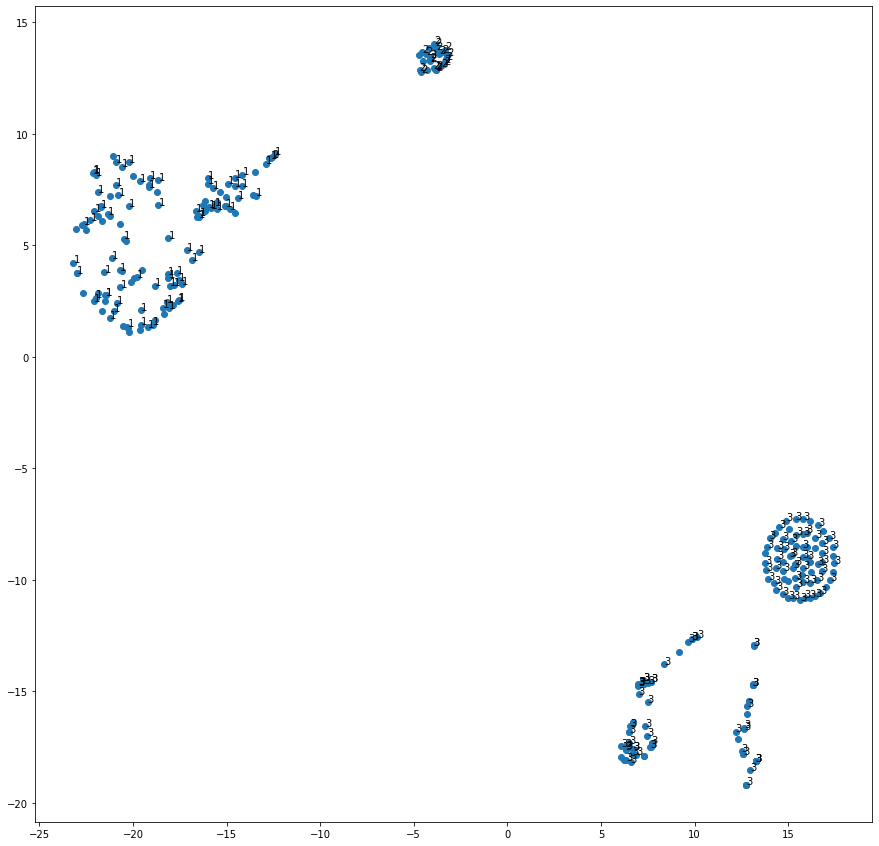

In [101]:
plt.figure(figsize=(15,15))
plt.scatter(projected_threads[:,0], projected_threads[:, 1])

for i in range(len(included_threads)):
    if random.random() < 0.7:
        plt.annotate(corpus.get_utterance(convo_ids[included_threads[i]]).meta['subreddit'][0], (projected_threads[i][0], projected_threads[i][1]))
    
plt.show()

## What if we did it with static hyperconvo features?

In [65]:
import pandas as pd

In [58]:
hc = convokit.HyperConvo(prefix_len=20)

In [59]:
hc.transform(corpus)

In [60]:
threads_feats = dict()

for convo in corpus.iter_conversations():
    threads_feats[convo.id] = convo.meta['hyperconvo']
    
def clean_value(x):
    if np.isinf(x) or np.isnan(x):
        return -1
    return x

In [62]:
feat_names = list(next(iter(threads_feats.values())).keys())

In [63]:
thread_ids = []
feats = []
for key, feat_dict in threads_feats.items():
    thread_ids.append(key)
    feats.append([clean_value(feat_dict[k]) for k in feat_names])

In [66]:
feat_df = pd.DataFrame(data=feats, index=thread_ids, columns=feat_names)

In [68]:
from sklearn.impute import SimpleImputer

In [69]:
feat_mtx = SimpleImputer(missing_values=-1).fit_transform(feat_df.values)
feat_mtx = StandardScaler().fit_transform(feat_mtx)

In [71]:
svd = TruncatedSVD(n_components=3, algorithm='arpack') # deals with an issue where the randomized alg hangs
svd.fit(feat_mtx)
U, s, V = svd.transform(feat_mtx) / svd.singular_values_, \
        svd.singular_values_, \
        svd.components_.T

In [72]:
U_norm = Normalizer().fit_transform(U)
V_norm = Normalizer().fit_transform(V)
U_df = pd.DataFrame(data=U_norm, index=feat_df.index)
V_df = pd.DataFrame(data=V_norm, index=feat_names)

In [103]:
tsne_hc = TSNE(random_state=2018)
tsne_hc_df = pd.DataFrame(data=tsne_hc.fit_transform(feat_df.values),
                      index=feat_df.index)

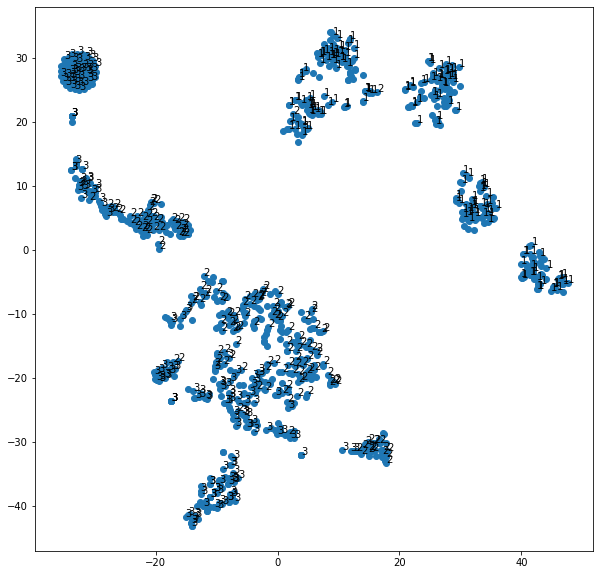

In [104]:
plt.figure(figsize=(10,10))
plt.scatter(tsne_hc_df[0].values, tsne_hc_df[1].values)
for i, txt in enumerate(tsne_df.index):
    if random.random() < 0.5:
        plt.annotate(corpus.get_utterance(txt).meta['subreddit'][0], (tsne_hc_df.values[i,0], tsne_hc_df.values[i,1]))
plt.show()

In [32]:
for convo in corpus.iter_conversations():
    for idx, utt in enumerate(convo.get_chronological_utterance_list()):
        utt.meta['order'] = idx

In [33]:
def get_convo_details(convo):
    print("Subreddit: {}".format(convo.get_utterance(convo.id).meta['subreddit']))
    convo.print_conversation_structure(lambda utt: str(utt.meta['order']) + ". " + utt.user.id, limit=20)

### Tiny right cluster: focused + selective

In [34]:
get_convo_details(corpus.get_conversation('dpkvykx'))

Subreddit: Random_Acts_Of_Amazon
1. InThisHouse19
    2. Yokuo
        3. InThisHouse19
            4. Yokuo
                5. InThisHouse19
                    6. Yokuo
                        7. InThisHouse19
                            8. Yokuo
                                9. InThisHouse19
                                    10. Yokuo
                                        11. InThisHouse19
                                            12. Yokuo
                                                13. InThisHouse19
                                                    14. Yokuo
                                                        15. InThisHouse19
                                                            16. Yokuo
                                                                17. InThisHouse19
                                                                    18. Yokuo
                                                                        19. InThisHouse19
                      

In [35]:
get_convo_details(corpus.get_conversation('e4aa708'))

Subreddit: DebateReligion
1. novagenesis
    2. Chef_Fats
        3. novagenesis
            4. Chef_Fats
                5. novagenesis
                    6. Chef_Fats
                        7. novagenesis
                            8. Chef_Fats
                                9. novagenesis
                                    10. Chef_Fats
                                        11. novagenesis
                                            12. Chef_Fats
                                                13. novagenesis
                                                    14. Chef_Fats
                                                        15. novagenesis
                                                            16. Chef_Fats
                                                                17. novagenesis
                                                                    18. Chef_Fats
                                                                        19. novagenesis
             

### Top islets: dyadic + 1 extra (focused + selective)

In [36]:
get_convo_details(corpus.get_conversation('e3pvvql'))

Subreddit: news
1. howHardIsIt2SignUp
    2. goosecarr
    3. OfficialDudeGuy
        4. howHardIsIt2SignUp
            5. OfficialDudeGuy
                6. howHardIsIt2SignUp
                    7. OfficialDudeGuy
                        8. howHardIsIt2SignUp
                            9. OfficialDudeGuy
                                10. howHardIsIt2SignUp
                                    11. OfficialDudeGuy
                                        12. howHardIsIt2SignUp
                                            13. OfficialDudeGuy
                                                14. howHardIsIt2SignUp
                                                    15. OfficialDudeGuy
                                                        16. howHardIsIt2SignUp
                                                            17. OfficialDudeGuy
                                                                18. howHardIsIt2SignUp
                                                                

In [37]:
get_convo_details(corpus.get_conversation('e2m6rwi'))

Subreddit: Drugs
1. LSDkid269
    2. FarGrape
        3. LSDkid269
            4. FarGrape
            5. DudeWhereIsMyPipe
                6. LSDkid269
                    7. DudeWhereIsMyPipe
                        8. LSDkid269
                            9. DudeWhereIsMyPipe
                                10. LSDkid269
                                    11. DudeWhereIsMyPipe
                                        12. LSDkid269
                                            13. DudeWhereIsMyPipe
                                                14. LSDkid269
                                                    15. DudeWhereIsMyPipe
                                                        16. LSDkid269
                                                            17. DudeWhereIsMyPipe
                                                                18. LSDkid269
                                                                    19. DudeWhereIsMyPipe
                                        

In [38]:
get_convo_details(corpus.get_conversation('dug6cc3'))

Subreddit: pokemontrades
1. trollolly
    2. ZiR1402
        3. trollolly
            4. ZiR1402
                5. trollolly
                6. trollolly
                    7. ZiR1402
                        8. trollolly
                            9. ZiR1402
                                10. trollolly
                                    11. ZiR1402
                                        12. trollolly
                                            13. ZiR1402
                                                14. trollolly
                                                    15. ZiR1402
                                                        16. trollolly
                                                            17. ZiR1402
                                                                18. trollolly
                                                                    19. ZiR1402
                                                                        20. trollolly


### Right cluster: interleaved (focused + expansionary) + generalized reciprocity

In [39]:
get_convo_details(corpus.get_conversation('duvrxdv'))

Subreddit: tifu
1. beersykins
    2. bruhhhhh69
        3. Government_spy_bot
            4. bruhhhhh69
            5. thedoormanmusic32
                7. bruhhhhh69
        8. pumpkinsnice
            9. Geta-Ve
            10. bruhhhhh69
                17. UniqueUsername171
        11. Ess2s2
            18. bruhhhhh69
                19. Ess2s2
        13. darksugarrose
    6. Halomir
        14. 1111thatsfiveones
    12. darksugarrose
        16. bruhhhhh69
    15. Autarch_Kade
        20. beersykins


In [40]:
get_convo_details(corpus.get_conversation('dy5m157'))

Subreddit: ShingekiNoKyojin
1. MisterX217
    2. larrycornflakies
        4. MisterX217
            7. PorcoBestBoy
                13. larrycornflakies
            10. ConnieConman
                12. PorcoBestBoy
            11. larrycornflakies
    3. ConnieConman
        8. MisterX217
            14. ConnieConman
    5. PorcoBestBoy
        15. MisterX217
            17. -ItsMatty
    6. -ItsMatty
        16. MisterX217
            19. -ItsMatty
    9. Hist2506
        18. MisterX217
    20. boss_on_air


In [41]:
get_convo_details(corpus.get_conversation('e1zcbou'))

Subreddit: singapore
1. i_like_cheeseburger
    2. [deleted]
        3. i_like_cheeseburger
    4. morethanmeetsdi
        5. [deleted]
            9. morethanmeetsdi
        6. i_like_cheeseburger
            10. [deleted]
                16. i_like_cheeseburger
                    19. undertheseea
                        20. i_like_cheeseburger
            15. morethanmeetsdi
            18. undertheseea
    7. lockheed_2000
        11. i_like_cheeseburger
            13. 1masterbaited
                17. i_like_cheeseburger
    8. rheinl
        12. morethanmeetsdi
        14. i_like_cheeseburger


In [42]:
get_convo_details(corpus.get_conversation('e3bu3le'))

Subreddit: anime
1. AmethystItalian
    2. Pivotfan3001
        5. AmethystItalian
            7. Pivotfan3001
    3. TheRiyria
        11. AmethystItalian
            12. TheRiyria
    4. Fred_MK
    6. MetaThPr4h
        10. AmethystItalian
    8. Gaporigo
        9. AmethystItalian
    13. lilyvess
        15. AmethystItalian
            19. Fred_MK
        16. sonlun96
    14. AxtheCool
    17. Cacophon
        18. AmethystItalian
    20. CommanderSevan


### Leftmost cluster: interleaved (focused + expansionary) + limited/no reciprocity

In [43]:
get_convo_details(corpus.get_conversation('dsy5s8q'))

Subreddit: The_Donald
1. nunsinnikes
    2. DontThinkChewSoap
        5. LiberalTearsLMFAO
        7. heisenburg69
        13. Jazpan
    3. ssentrep
    4. dixond
        10. RobertSparks777
    6. HellbillyDeluxe
        11. MichiganManMatt
        20. faintlight
    8. denizen42
        16. xenophobe51
    9. RobertSparks777
    12. PossiblyaShitposter
        17. xenophobe51
            19. PossiblyaShitposter
    14. StickitFlipit
    15. Sirdreadick
        18. xenophobe51


In [44]:
get_convo_details(corpus.get_conversation('e6kbukq'))

Subreddit: hockey
1. -whostolemyusername-
    2. marsneedstowels
        7. Cromasters
            12. stramjummer
        8. Derpadoodoo
        18. hal64
    3. miner88
        4. Da-Aaron
        5. pensbird91
    6. 1337nerd
    9. Tyrxgow33
        10. MirabelleC
            14. hamsterkill
        11. kitchen_cents
            13. hamsterkill
                16. IAmGrum
                    17. hamsterkill
                    19. younggun92
            15. IAmGrum
    20. KikiFlowers


In [45]:
get_convo_details(corpus.get_conversation('dypnn6w'))

Subreddit: mildlyinfuriating
1. mrskipperoo
    2. willparry79
    3. Sylnce
        7. _Citizenkane
            9. Reductive
                16. Deltamon
            18. ElectronUS97
        8. ignorantbirds
            10. excalibron
        12. tremens
            13. RawketPropelled
                14. tremens
        17. aman207
    4. astutesnoot
    5. TwatsThat
        11. foxesareokiguess
    6. leoleosuper
    15. 404-Fuck-Not-Found
    19. krathil
    20. Emile_Zolla


### Bottom cluster: focused -> both, interweaved, no reciprocity

In [46]:
get_convo_details(corpus.get_conversation('drda1f6'))

Subreddit: cringepics
1. Lilithiumandias
    2. UWannaStartAFight
        3. TodayILoled
            18. whitesocksflipflops
        8. critical_thought21
            12. Im_int
                15. Dlrlcktd
    4. EpicPhail60
        5. djene_djene
        7. nabil-xel-sahara
            10. SpellsThatWrong
        20. P1kachu_assassin
    6. quakertroy
    9. TheDerpofYork
    11. DeckerR
    13. AJ2KB
    14. Fenastus
    16. Mattjbr2
        17. Lilithiumandias
    19. goodjobgabe


In [47]:
get_convo_details(corpus.get_conversation('duxugq9'))

Subreddit: WTF
1. Honkadoo
    2. Isaacvithurston
        3. slightlyuseful
            4. Brainwash_TV
                5. alexnader
                14. DRock3d
            7. junttiana
            9. pegicorn
        10. vincidahk
        15. MrPringles23
            18. Isaacvithurston
        19. 10z20Luka
    6. sabrefudge
    8. NeonBelly_
    11. bendover912
        16. jdayatwork
        17. HollywooHero
    12. RadSpaceWizard
    13. surfANDmusic
    20. FlusteredByBoobs


In [48]:
get_convo_details(corpus.get_conversation('e5oium2'))

Subreddit: movies
1. GarlicPotatoFriends
    2. ChemEcalgineer
        4. tourettes1992
            5. Smallgenie549
            6. Darddeac
                12. Doctor_watts
            7. Kinoman69
                14. Penny-Wise_
                19. Mattyzooks
            9. L1vingTribunal
                18. SetBrainInCmplxPlane
            10. bob1689321
            15. MasterofSciFi
        8. Locke108
        17. haywoodyamilkme
    3. WellesCane
    11. GREATGEEKGODofficial
        13. eifersucht12a
            20. WritingScreen
    16. carolinemathildes


### Central cluster: both (interleaved) -- maybe expansionary -> both?, generalized reciprocity

In [49]:
get_convo_details(corpus.get_conversation('dyyxkkr'))

Subreddit: raisedbynarcissists
1. NaiveEnthusiast
    2. CheekyKarmaOwl
    3. cbeep
    4. decidedlyindecisive
        7. Gnomend
            10. bo_della
            11. messedupbeyondbelief
                14. decidedlyindecisive
                    16. messedupbeyondbelief
                        18. decidedlyindecisive
                            19. messedupbeyondbelief
                                20. decidedlyindecisive
        13. chopstiks
            15. decidedlyindecisive
    5. attnpleasedont
    6. Arcadia-ego
    8. cryptohobo
    9. rbnthrowawayAce
    12. kagurawinddemon
    17. CatSimpatico


In [50]:
get_convo_details(corpus.get_conversation('dywn7fb'))

Subreddit: tifu
1. Death_by_Corgi
    2. MatthewJamesAudio
        20. SpiritTalker
    3. Hyperversum
    4. MichieD
        9. AlmightyStarfire
    5. LastOne_Alive
        6. Ruffblade027
            12. EnkoNeko
        7. aron9forever
            8. YamnaT777
            10. AlmightyStarfire
            13. gromwell_grouse
                14. aron9forever
            15. Joint-User
    11. nightwica
    16. bigshowwweeeellllll
    17. AndroidUser8
    18. ThingsThatAreBlue
    19. Let_you_down


In [51]:
get_convo_details(corpus.get_conversation('e42jk3c'))

Subreddit: Christianity
1. nogginrocket
    2. LegioVIFerrata
        4. Cheeze_It
            5. hierocles_
                7. Apa300
                14. key_lime_pie
    3. hierocles_
        6. strange_fate
            8. hierocles_
        9. Apa300
            10. Rabbits4cats
                13. Apa300
                    18. coffeefueledKM
                        19. Rabbits4cats
                            20. faughaballagh
        11. Tiwazdom
        12. nogginrocket
        15. smileypants707
        16. WOTWOTX2
        17. WackedWacko


In [52]:
get_convo_details(corpus.get_conversation('dqtpfoj'))

Subreddit: CFB
1. XvS_W4rri0r
    2. N-Your-Endo
        3. wiscowonder
            8. TheColtOfPersonality
                9. BorgSeduction
                    12. Gumbeaux_
                        20. FSUfan35
                    16. MasterGrok
                13. XvS_W4rri0r
                    15. TheColtOfPersonality
                17. Piano_Fingerbanger
    4. okiewxchaser
        7. Whosdaman
            10. WeAreBert
                18. Chicken_witha_Bat
        11. NihilisticOkie
    5. I_CAN_SMELL_U
    6. See_Lindsey_Run
    14. JayRS11
    19. antiherowes
